In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import os
import zipfile

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [47]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
DATA_DIR = "data"
ZIP_PATH = os.path.join(DATA_DIR, "smsspamcollection.zip")
EXTRACTED_FILE = os.path.join(DATA_DIR, "SMSSpamCollection")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(EXTRACTED_FILE):
    print("Downloading dataset...")
    urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")

# Load dataset into pandas DataFrame
df = pd.read_csv(EXTRACTED_FILE, sep='\t', header=None, names=['label', 'message'])
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nDataset info:")
print(df.info())

Dataset already exists.
Dataset shape: (5572, 2)

First 5 rows of the dataset:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


Dataset Overview:
Total samples: 5572
Number of ham (non-spam) messages: 4825
Number of spam messages: 747
Spam percentage: 13.41%


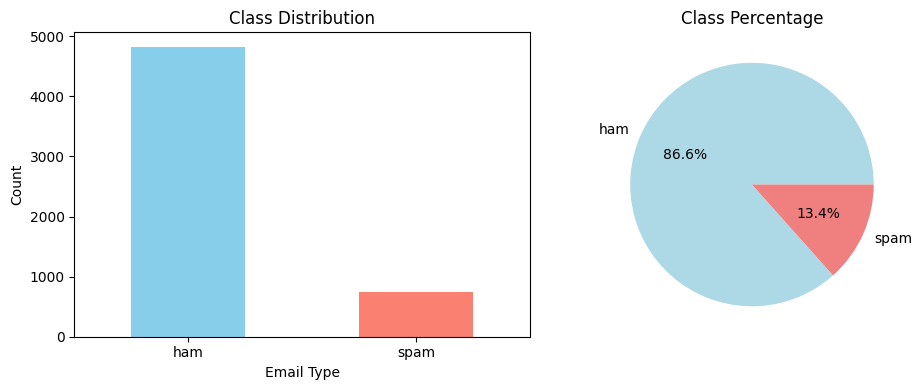


Message length statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0


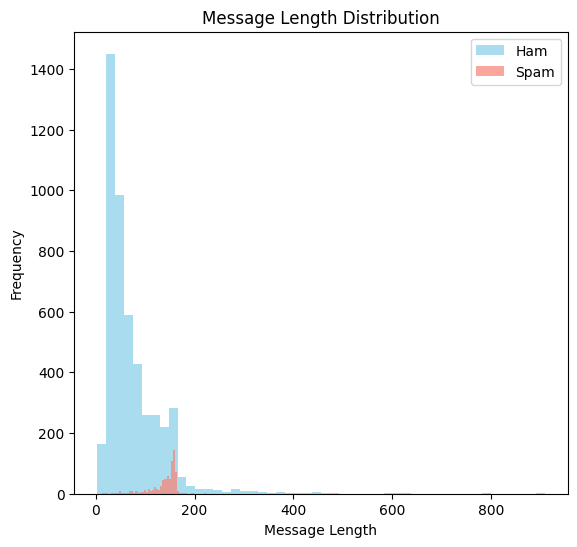

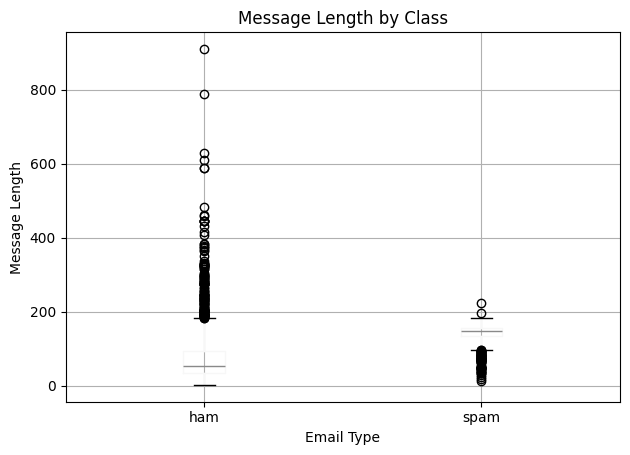

In [83]:
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Number of ham (non-spam) messages: {len(df[df['label'] == 'ham'])}")
print(f"Number of spam messages: {len(df[df['label'] == 'spam'])}")
print(f"Spam percentage: {(len(df[df['label'] == 'spam']) / len(df)) * 100:.2f}%")

# Plot class distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Class Percentage')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Message length analysis
df['message_length'] = df['message'].apply(len)
print("\nMessage length statistics:")
print(df.groupby('label')['message_length'].describe())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df[df['label'] == 'ham']['message_length'].plot(kind='hist', bins=50, alpha=0.7, label='Ham', color='skyblue')
df[df['label'] == 'spam']['message_length'].plot(kind='hist', bins=50, alpha=0.7, label='Spam', color='salmon')
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 1)
df.boxplot(column='message_length', by='label')
plt.title('Message Length by Class')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Email Type')
plt.ylabel('Message Length')

plt.tight_layout()
plt.show()

In [84]:
# Convert labels to binary (ham=0, spam=1)
df['label_num'] = df.label.map({'ham': 0, 'spam': 1})

# Check for missing values
print("Missing values check:")
print(df.isnull().sum())

# Display sample of processed data
print("\nSample of processed data:")
display(df[['label', 'label_num', 'message']].head())

# Show class distribution after conversion
print(f"\nClass distribution (numeric):")
print(df['label_num'].value_counts())

Missing values check:
label             0
message           0
message_length    0
label_num         0
dtype: int64

Sample of processed data:


,label,label_num,message
0,ham,0,"Go until jurong point, crazy.. Available only ..."
1,ham,0,Ok lar... Joking wif u oni...
2,spam,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,0,U dun say so early hor... U c already then say...
4,ham,0,"Nah I don't think he goes to usf, he lives aro..."



Class distribution (numeric):
label_num
0    4825
1     747
Name: count, dtype: int64


In [85]:
X = df['message']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in testing set:")
print(y_test.value_counts())

# Display some sample messages from each set
print("\nSample training messages:")
for i, msg in enumerate(X_train.head(3)):
    print(f"{i+1}. {msg[:100]}...")

print("\nSample testing messages:")
for i, msg in enumerate(X_test.head(3)):
    print(f"{i+1}. {msg[:100]}...")

Training samples: 4457
Testing samples: 1115

Class distribution in training set:
label_num
0    3859
1     598
Name: count, dtype: int64

Class distribution in testing set:
label_num
0    966
1    149
Name: count, dtype: int64

Sample training messages:
1. He will, you guys close?...
2. CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER IF URGOIN OUTL8R,JUST REALLYNEED 2DOCD.PLEASE DONTPLEA...
3. Ok k..sry i knw 2 siva..tats y i askd.....

Sample testing messages:
1. No need to buy lunch for me.. I eat maggi mee.....
2. Ok im not sure what time i finish tomorrow but i wanna spend the evening with you cos that would be ...
3. Waiting in e car 4 my mum lor. U leh? Reach home already?...


In [86]:
# Create the pipeline components
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=5,
    max_features=10000
)

log_reg = LogisticRegression(solver='liblinear', random_state=42)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', log_reg)
])

print("Pipeline created successfully!")
print("\nPipeline steps:")
for step_name, step in pipeline.steps:
    print(f"- {step_name}: {step.__class__.__name__}")

# Let's first fit the pipeline with default parameters to understand the feature extraction
print("\nFitting TF-IDF vectorizer to understand feature extraction...")
X_tfidf = tfidf.fit_transform(X_train)
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

# Show some features
print(f"\nSample features (first 20): {tfidf.get_feature_names_out()[:20]}")

Pipeline created successfully!

Pipeline steps:
- tfidf: TfidfVectorizer
- clf: LogisticRegression

Fitting TF-IDF vectorizer to understand feature extraction...
Shape of TF-IDF matrix: (4457, 1774)
Number of features: 1774

Sample features (first 20): ['00' '00 sub' '000' '000 cash' '02' '03' '03 2nd' '04' '06' '0800'
 '08000839402' '08000839402 call2optout' '08000930705' '0870'
 '0870 national' '08707509020' '08707509020 just' '08712300220'
 '08712460324' '08718720201']


In [87]:
param_grid = {
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

print("Starting GridSearchCV...")
print(f"Number of parameter combinations: {len(param_grid['tfidf__max_df']) * len(param_grid['tfidf__ngram_range']) * len(param_grid['clf__C']) * len(param_grid['clf__penalty'])}")
print(f"Number of CV folds: 5")
print(f"Total fits: {5 * len(param_grid['tfidf__max_df']) * len(param_grid['tfidf__ngram_range']) * len(param_grid['clf__C']) * len(param_grid['clf__penalty'])}")

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train the model with grid search
grid_search.fit(X_train, y_train)

print("\nGridSearch completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Display all results
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 parameter combinations:")
display(results_df[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head())

Starting GridSearchCV...
Number of parameter combinations: 36
Number of CV folds: 5
Total fits: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GridSearch completed!
Best parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
Best cross-validation F1 score: 0.9316

Top 5 parameter combinations:


,params,mean_test_score,std_test_score
30,"{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__m...",0.931571,0.009370
32,"{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__m...",0.931571,0.009370
34,"{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__m...",0.931571,0.009370
31,"{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__m...",0.930057,0.010437
33,"{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__m...",0.930057,0.010437


Model Evaluation Results:

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



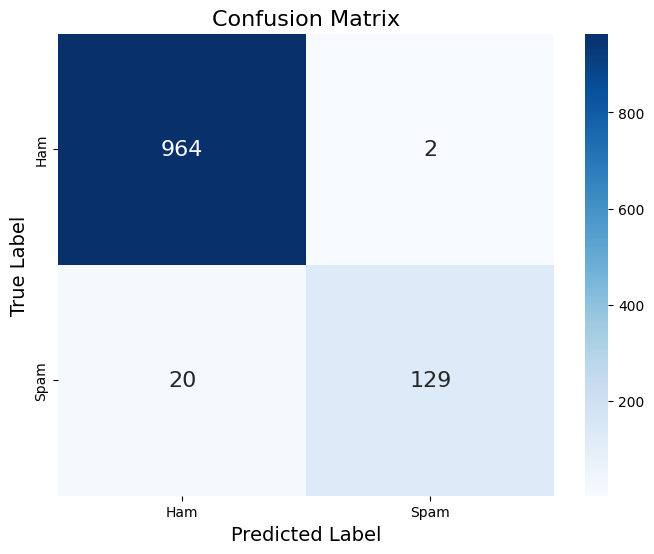

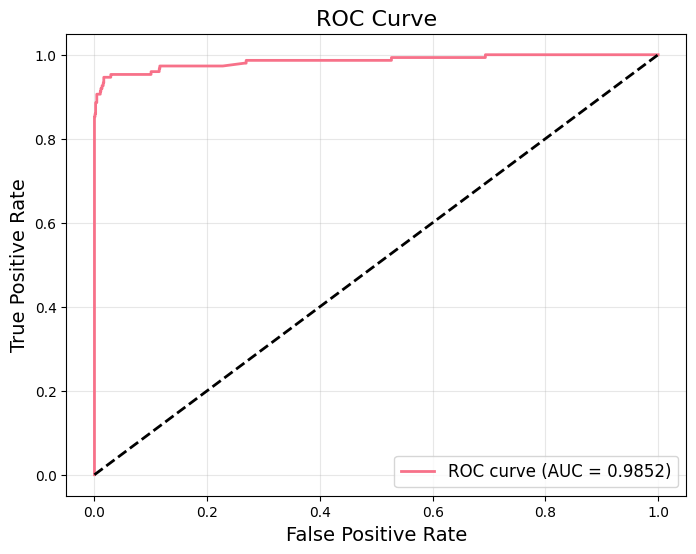

AUC Score: 0.9852


In [88]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Model Evaluation Results:")
print("=" * 50)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'],
            annot_kws={'size': 16})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {auc_score:.4f}")

Top 20 features for spam detection:


,feature,coefficient,abs_coefficient
1214,uk,7.330351,7.330351
1209,txt,7.284534,7.284534
26,150p,6.391332,6.391332
760,mobile,6.369770,6.369770
242,claim,5.818998,5.818998
1019,service,5.541194,5.541194
962,reply,5.503845,5.503845
53,50,5.483785,5.483785
1324,www,5.376914,5.376914
805,new,4.951340,4.951340


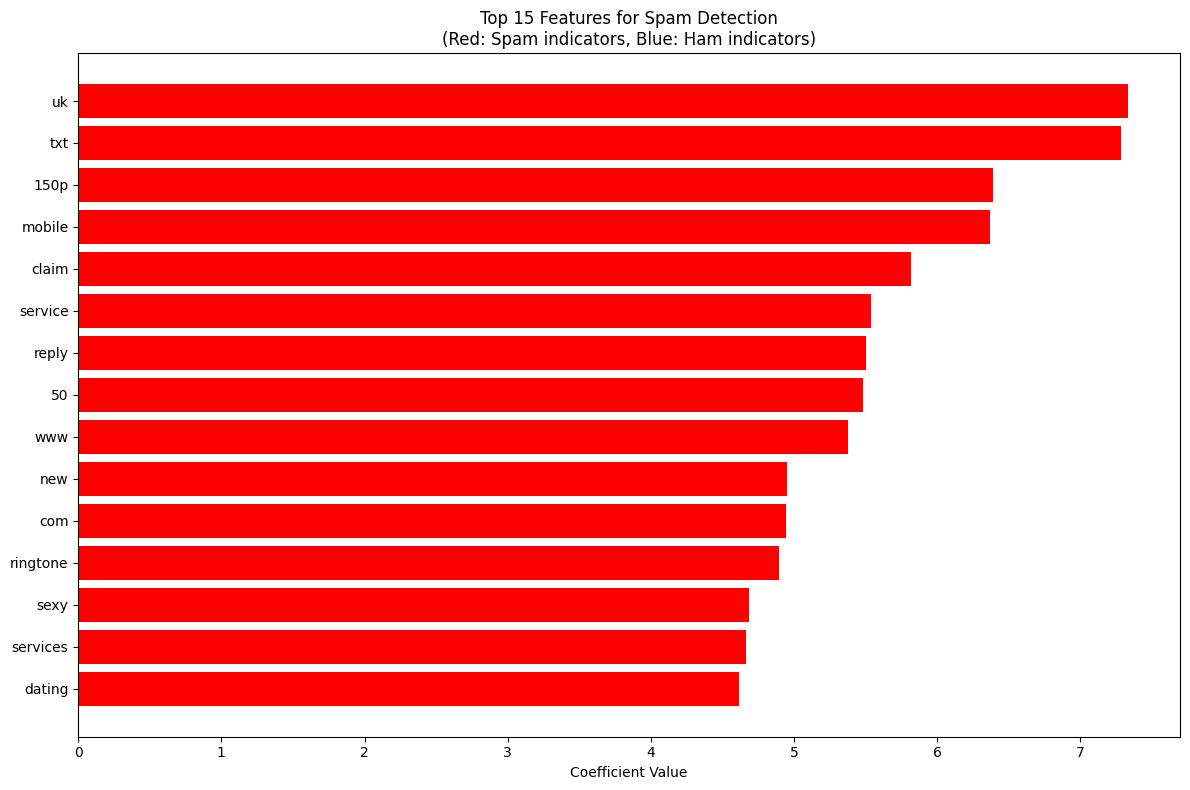


Model Predictions on Example Messages:
1. Congratulations! You've won a $1000 gift card. Click here to claim your prize!
   Prediction: SPAM (Probability: 0.8891)

2. Hey, are we still meeting for lunch tomorrow?
   Prediction: HAM (Probability: 0.0018)

3. URGENT: Your bank account needs verification. Please click the link to secure your account.
   Prediction: SPAM (Probability: 0.5388)

4. Thanks for your email. I'll get back to you soon.
   Prediction: HAM (Probability: 0.0025)

5. FREE iPhone for you! Just reply with your address to claim your free gift!
   Prediction: SPAM (Probability: 0.9082)



In [91]:
# Get feature importance
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
coefficients = best_model.named_steps['clf'].coef_[0]

# Create a DataFrame of features and their coefficients
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute value of coefficient
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Top 20 features for spam detection:")
print("=" * 50)
display(feature_importance.head(20))

# Plot top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if coef > 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Features for Spam Detection\n(Red: Spam indicators, Blue: Ham indicators)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Test the model on some example messages
test_messages = [
    "Congratulations! You've won a $1000 gift card. Click here to claim your prize!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account needs verification. Please click the link to secure your account.",
    "Thanks for your email. I'll get back to you soon.",
    "FREE iPhone for you! Just reply with your address to claim your free gift!"
]

print("\nModel Predictions on Example Messages:")
print("=" * 60)
for i, message in enumerate(test_messages, 1):
    proba = best_model.predict_proba([message])[0][1]
    prediction = "SPAM" if best_model.predict([message])[0] == 1 else "HAM"
    print(f"{i}. {message}")
    print(f"   Prediction: {prediction} (Probability: {proba:.4f})")
    print()

In [92]:
import joblib

# Save the best model
joblib.dump(best_model, 'spam_classifier_model.pkl')
print("Model saved as 'spam_classifier_model.pkl'")

# Final summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")
print(f"Test AUC Score: {auc_score:.4f}")
print(f"Number of features: {len(feature_names)}")
print(f"Model type: {best_model.named_steps['clf'].__class__.__name__}")

# Load the model to verify it works
loaded_model = joblib.load('spam_classifier_model.pkl')
print(f"\nModel loaded successfully: {type(loaded_model)}")

# Test the loaded model
test_message = "Congratulations! You won a prize!"
prediction = loaded_model.predict([test_message])[0]
print(f"Test prediction on '{test_message}': {'SPAM' if prediction == 1 else 'HAM'}")

Model saved as 'spam_classifier_model.pkl'

FINAL MODEL SUMMARY
Best parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
Best CV F1 Score: 0.9316
Test AUC Score: 0.9852
Number of features: 1347
Model type: LogisticRegression

Model loaded successfully: <class 'sklearn.pipeline.Pipeline'>
Test prediction on 'Congratulations! You won a prize!': SPAM
